# Cox regressions on ICB genomic variants

We now have
- preprocessed OncoPanel data for a larger GBM ICB cohort
- clinical data for this cohort (e.g., OS, newly diagnosed vs. recurrent status)

Here, we want to combine the mutation calls from the exome and panel data and then to apply the Cox regression methodology from the exome analysis to this combined dataset.

This notebook also tests associations between (i) Verhaak expression subtype scores and (ii) genomic variants. It generates the boxplots in Fig. 1h.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import palettable

from lifelines import CoxPHFitter
from statsmodels.stats.multitest import multipletests

# Setup

In [3]:
oncopanel_variants_path = "../data/oncopanel_all_variants_standardized_oncokb.tsv" 
oncopanel_clinical_path = "../data/oncopanel_clinical.xlsx" 
patient_sheet_path = "../data/participant_cohort_sheet.tsv" 
sample_sheet_path = "../data/sample_cohort_sheet.tsv" 
wes_variants_path = "../data/muts_cnas_combined.pkl" 

oncopanel_variants = pd.read_csv(oncopanel_variants_path, sep = '\t')
oncopanel_clinical = pd.read_excel(oncopanel_clinical_path)
patient_sheet = pd.read_csv(patient_sheet_path, sep = '\t')
sample_sheet = pd.read_csv(sample_sheet_path, sep = '\t')
wes_variants = pd.read_pickle(wes_variants_path)

# Prepare variants

## OncoPanel

In [4]:
oncopanel_variants = oncopanel_variants.merge(oncopanel_clinical[['id_uniquesample', 'id_broad_sample', 'id_icb']],
                                              left_on = 'Sample_ID', right_on = 'id_uniquesample')

oncopanel_variants['Sample_ID'] = np.where(oncopanel_variants['id_broad_sample'].notnull(),
                                           oncopanel_variants['id_broad_sample'],
                                           oncopanel_variants['Sample_ID']).astype(str)

oncopanel_variants.replace({'GBM.ICB-3-14.637.Post.FFbank': 'GBM.ICB-3-14.233.Pre'}, inplace = True)

# oncopanel_variants['Patient_ID'] = oncopanel_variants['id_icb'].apply(lambda x: 'GBM.ICB-' + str(x))

oncopanel_variants.head()

,Patient_ID,Sample_ID,Hugo_Symbol,unique_mut_id,PHRED,MUTATION_EFFECT,cna,id_uniquesample,id_broad_sample,id_icb
0,101954597,1019543883876,TP53,17_7578406_C_T,24.2,Loss-of-function,NaN,1019543883876,NaN,221
1,101954597,1019543883876,RB1,13_48916769_G_GA,32.0,Likely Loss-of-function,NaN,1019543883876,NaN,221
2,1019542469,GBM.ICB-1-10.533.A2-Pre,SETBP1,18_42531179_G_A,26.8,NaN,NaN,1019543884287,GBM.ICB-1-10.533.A2-Pre,1
3,1019542469,GBM.ICB-1-10.533.A2-Pre,PTEN,10_89624272_T_TA,33.0,Likely Loss-of-function,NaN,1019543884287,GBM.ICB-1-10.533.A2-Pre,1
4,101954801,GBM.ICB-3-14.233.Pre,PIK3CA,3_178927979_CTGTCCA_C,21.8,NaN,NaN,1019543884834,GBM.ICB-3-14.233.Pre,3


In [5]:
oncopanel_pts = set(sample_sheet.loc[sample_sheet['usable_oncopanel'], 'participant_id_legacy'])
len(oncopanel_pts)

155

In [6]:
oncopanel_samples_idx = sample_sheet[sample_sheet['usable_oncopanel']].groupby('participant_id_legacy')['collection_date_dfd'].idxmax()
oncopanel_samples = sample_sheet.loc[oncopanel_samples_idx, 'sample_id_legacy'].astype(str)

oncopanel_variants_latest_pre = oncopanel_variants[oncopanel_variants['Sample_ID'].isin(oncopanel_samples)]
oncopanel_variants_latest_pre = oncopanel_variants_latest_pre.merge(sample_sheet[['sample_id_legacy', 'participant_id_legacy']], how = 'left', left_on = 'Sample_ID', right_on = 'sample_id_legacy')
oncopanel_variants_latest_pre['Patient_ID'] = oncopanel_variants_latest_pre['participant_id_legacy']

oncopanel_variants_latest_pre['Patient_ID'].nunique()

153

## WES

In [7]:
wes_pts = sample_sheet.loc[sample_sheet['usable_wes'] &
                           (sample_sheet['pre_post'] == 'Pre') &
                           (~sample_sheet['participant_id_legacy'].isin(oncopanel_pts)) &
                           (sample_sheet['tumor_normal'] == 'tumor'),
                           'participant_id_legacy'].unique()

len(wes_pts)

12

In [8]:
wes_variants_no_op = wes_variants[wes_variants['Patient_ID'].isin(wes_pts)]

wes_variants_no_op['Patient_ID'].nunique()

12

# Combine the variant calls

In [9]:
variants = pd.concat([oncopanel_variants_latest_pre, wes_variants_no_op])

# LoH in WES = DEL in OP
variants.loc[variants['cna'] == 'LoH', 'cna'] = 'DEL'

In [10]:
variants['Patient_ID'].nunique()

165

In [11]:
variants['MUTATION_EFFECT'].value_counts(dropna = False)

NaN                        1056
Likely Loss-of-function     103
Gain-of-function             40
Likely Gain-of-function      18
Loss-of-function             16
Unknown                       4
Name: MUTATION_EFFECT, dtype: int64

In [12]:
variants['cna'].value_counts(dropna = False)

DEL               411
NaN               354
AMP               311
DeepDEL           120
HighAMP            29
Biallelic_Loss      5
GAIN                4
FocalHighAMP        3
Name: cna, dtype: int64

# Combine and tidy the clinical data

In [13]:
pre_patients = sample_sheet[(sample_sheet['pre_post'] == 'Pre') & (sample_sheet['tumor_normal'] == 'tumor') & (sample_sheet['usable_oncopanel'] | sample_sheet['usable_wes'])]['participant_id_legacy'].unique()

clinical = patient_sheet[patient_sheet['participant_id_legacy'].isin(pre_patients)].rename(columns = {'Deceased': 'deceased', 'MGMT methylated Y/N': 'mgmt_methylated', 'ICB for Newly diagnosed': 'icb_setting'})

set(pre_patients) - set(variants['Patient_ID'])

{'GBM.ICB-223', 'GBM.ICB-233'}

In [14]:
for c in ['deceased', 'mgmt_methylated', 'icb_setting']:
    print(clinical[c].value_counts(dropna = False))
    print('\n')

Deceased    154
Alive        13
Name: deceased, dtype: int64


Unmethylated    92
Methylated      53
Partially       12
NaN             10
Name: mgmt_methylated, dtype: int64


Recurrent          129
Newly-diagnosed     38
Name: icb_setting, dtype: int64




In [15]:
clinical = clinical.replace({'Deceased': 1.0, 'Alive': 0.0,
                             'Unmethylated': 0.0, 'Methylated': 1.0, 'Partially': 1.0,
                             'Recurrent': 0.0, 'Newly-diagnosed': 1.0})

clinical['mgmt_methylated'] = clinical['mgmt_methylated'].fillna(0.0)

In [16]:
# Did we clean up everything?
for c in ['deceased', 'mgmt_methylated', 'icb_setting']:
    print(clinical[c].value_counts(dropna = False))
    print('\n')

1.0    154
0.0     13
Name: deceased, dtype: int64


0.0    102
1.0     65
Name: mgmt_methylated, dtype: int64


0.0    129
1.0     38
Name: icb_setting, dtype: int64




# Filter by a targeted list of variants

Load the targeted list

In [17]:
targeted_variant_tsv = "../data/Potential-WES-targets-ICB-GBM-12-5-23.tsv"
targeted_variant_df = pd.read_csv(targeted_variant_tsv, sep="\t")

Determine whether they specify CNAs or sequence variants

In [24]:
# We interpret the classifications from the targeted list in a very permissive way.
def is_cna(alt_str):
    return alt_str != "sequence variants"

def is_mut(alt_str):
    return alt_str != "amplification"

In [19]:
targeted_variant_df["is_cna"] = targeted_variant_df["Alteration"].map(is_cna)
targeted_variant_df["is_mut"] = targeted_variant_df["Alteration"].map(is_mut)

In [20]:
targeted_cna_genes = set(targeted_variant_df["Gene"][targeted_variant_df["is_cna"]])
targeted_mut_genes = set(targeted_variant_df["Gene"][targeted_variant_df["is_mut"]])
all_targeted_genes = targeted_cna_genes.union(targeted_mut_genes)

In [21]:
# How much do these sets overlap?
len(targeted_cna_genes.intersection(targeted_mut_genes))/len(targeted_cna_genes.union(targeted_mut_genes))

0.8461538461538461

# Prepare data for Cox regression

In [22]:
clinical.shape

(167, 48)

In [23]:
cnas = variants[variants['cna'].notnull()]
cnas_filt = cnas[cnas['Hugo_Symbol'].map(lambda g: g in all_targeted_genes)]
cnas_matrix = cnas_filt[['Patient_ID', 'Hugo_Symbol']].value_counts().unstack(level = 'Hugo_Symbol', fill_value = 0).astype('bool').astype('int')
cnas_matrix.columns = [c + '_cna' for c in cnas_matrix.columns]

print(cnas.shape, cnas_filt.shape)

(883, 25) (430, 25)


In [25]:
muts = variants[variants['unique_mut_id'].notnull() | variants['cna'].str.contains('Biallelic_Loss')]
muts_filt = muts[muts['Hugo_Symbol'].map(lambda g: g in all_targeted_genes)]
muts_matrix = muts_filt[['Patient_ID', 'Hugo_Symbol']].value_counts().unstack(level = 'Hugo_Symbol', fill_value = 0).astype('bool').astype('int')
muts_matrix.columns = [c + '_mut' for c in muts_matrix.columns]

print(muts.shape, muts_filt.shape)

(339, 25) (166, 25)


In [26]:
variants_matrix = muts_matrix.join(cnas_matrix, how = 'outer')
variants_matrix.fillna(0.0, inplace = True)

print(variants_matrix.shape)

(158, 33)


Keep only gene x sequence variant/CNA combinations with at least 2 patients having an alteration.

In [27]:
variants_matrix = variants_matrix.loc[:, variants_matrix.gt(0.0).sum() >= 2]
variants_matrix.shape

(158, 29)

Create a single dataframe of clinical and variant data.

Do this by merging left from the clinical data to keep patients without any variants called.

In [28]:
cox = clinical.merge(variants_matrix, how = 'left', left_on = 'participant_id_legacy', right_index = True).reset_index(drop = True)
cox.iloc[:, clinical.shape[1]:cox.shape[1]] = cox.iloc[:, clinical.shape[1]:cox.shape[1]].fillna(0.0)

print(cox.shape)
cox.head()

(167, 77)


,participant_id,Sex,osicb,deceased,os,Dx at time of ICB (DFCI),mgmt_methylated,Age at GBM Dx,KPS at initiation of ICB,Initial tumor location,...,CDKN2A_cna,CDKN2B_cna,MDM2_cna,MDM4_cna,MET_cna,NF1_cna,PDGFRA_cna,PTEN_cna,RB1_cna,TP53_cna
0,GBM-001,Male,1129.0,1.0,2915.0,"GBM, IDH-wt",1.0,51.9,90.0,Temporal,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,GBM-010,Male,398.0,1.0,1228.0,"GBM, IDH-wt",1.0,52.7,90.0,Parietal,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,GBM-102,Female,160.0,1.0,467.0,"GBM, IDH-wt",0.0,60.2,70.0,Temporal,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,GBM-103,Male,221.0,1.0,798.0,"GBM, IDH-wt",0.0,71.9,80.0,Temporal,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,GBM-104,Male,131.0,1.0,756.0,"GBM, IDH-wt",0.0,64.4,90.0,Parietal,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [29]:
variants[(variants['Hugo_Symbol'] == 'MDM4') & (variants['cna'].notnull())]['cna'].value_counts()

AMP             5
HighAMP         4
FocalHighAMP    1
GAIN            1
DEL             1
Name: cna, dtype: int64

# Fit a Cox regression for each alteration (gene x sequence variant/CNA)

## Newly diagnosed pts only

In [30]:
cox_nd = cox[cox['icb_setting'] == 1]
cox_nd.shape

(38, 77)

In [32]:
cox_nd[cox_nd['PDGFRA_cna'] == 1].shape

(1, 77)

In [33]:
variants[(variants['Hugo_Symbol'] == 'PDGFRA') & (variants['cna'].notnull())].shape

(8, 25)

In [35]:
estimator = CoxPHFitter()
stat_results = dict()

for alteration in list(variants_matrix):
    if cox_nd[alteration].sum() >= 2:
        estimator.fit(cox_nd[['osicb',
                           'deceased',
                           'mgmt_methylated',
                           alteration]],
                      duration_col = 'osicb',
                      event_col = 'deceased')

        # extract model coefficients
        stat_results[alteration] = estimator.summary[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']].values[-1].tolist()

        # n pts with mutation
        n_mut = len(cox_nd[cox_nd[alteration] == 1])
        stat_results[alteration].extend([n_mut])
    
stat_results_df = pd.DataFrame(stat_results).T.rename(columns = {0: 'exp(coef)', 1: 'exp(coef) lower 95%', 2: 'exp(coef) upper 95%', 3: 'p', 4: 'n_mut'}).sort_values('p')
stat_results_df['n_tot'] = len(cox_nd)
stat_results_df['p_adj'] = multipletests(stat_results_df['p'], alpha=0.1, method='fdr_bh')[1]
stat_results_df.to_csv('../results/cox_results_icb_newly_diagnosed.txt', sep='\t')

In [36]:
stat_results_df.head(10)

,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p,n_mut,n_tot,p_adj
CDKN2A_cna,5.990407,2.531132,14.177438,0.000046,14.0,38,0.000697
PDGFRA_mut,8.533097,2.144488,33.953903,0.002345,3.0,38,0.017587
MET_cna,2.177026,1.020153,4.645815,0.044267,18.0,38,0.221334
CDK6_cna,1.933012,0.956959,3.904591,0.066163,19.0,38,0.248110
CDKN2B_cna,1.860380,0.851038,4.066812,0.119771,11.0,38,0.359313
NF1_mut,2.062866,0.727535,5.849090,0.173277,5.0,38,0.374922
PTEN_mut,1.682209,0.793406,3.566684,0.174964,13.0,38,0.374922
RB1_cna,1.202302,0.444771,3.250060,0.716514,6.0,38,0.992292
TP53_cna,0.774971,0.180865,3.320606,0.731308,3.0,38,0.992292
MDM4_cna,1.272414,0.289735,5.587992,0.749644,2.0,38,0.992292


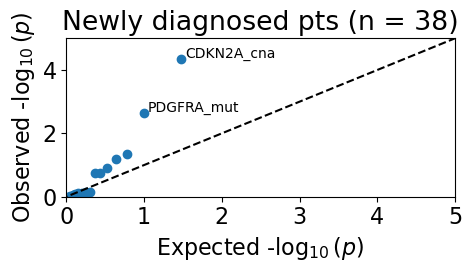

In [37]:
# P-value QQ Plot
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (5,3)

srt_idx = np.argsort(stat_results_df["p"]) + 0.5
stat_results_df["quantile"] = srt_idx/(stat_results_df.shape[0] - 0.0)
plt.scatter(-np.log10(stat_results_df["quantile"]), -np.log10(stat_results_df["p"]))
plt.plot([-1,5],[-1,5], linestyle="--", color="k")

for i, si in enumerate(srt_idx[:2]):
    plt.text(-np.log10(stat_results_df["quantile"].values[i])+0.05, -np.log10(stat_results_df["p"].values[i])+0.05,
             stat_results_df.index.values[i], size=10)

plt.xlim([-0.0,5])
plt.ylim([-0.0,5])
plt.xlabel("Expected -$\log_{10}(p)$")
plt.ylabel("Observed -$\log_{10}(p)$")
plt.title(f'Newly diagnosed pts (n = {len(cox_nd)})')
plt.tight_layout()
plt.show()

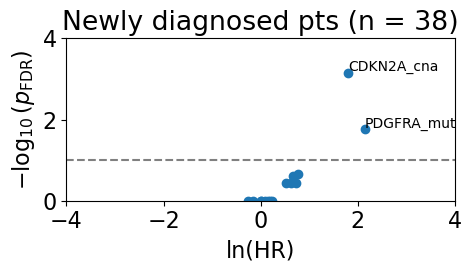

In [38]:
# Volcano plot
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (5,3)

ax = plt.gca()
ax.scatter(np.log(stat_results_df['exp(coef)']), -np.log10(stat_results_df['p_adj']))
ax.set_xlim(-4, 4)
ax.set_ylim(0, 4)
ax.set_xlabel('ln(HR)')
ax.set_ylabel('$-\log_{10}{(p_{\mathrm{FDR}})}$')
ax.axhline(y = -np.log10(0.1), color = 'grey', linestyle = '--')

for i, row in stat_results_df[stat_results_df['p_adj'] < 0.2].iterrows():
    ax.text(np.log(row['exp(coef)']+0.05), -np.log10(row['p_adj'])+0.05, i, size=10)

plt.title(f'Newly diagnosed pts (n = {len(cox_nd)})')
plt.tight_layout()
plt.show()

## Recurrent pts only

In [39]:
cox_r = cox[cox['icb_setting'] == 0]
cox_r.shape

(129, 77)

In [40]:
estimator = CoxPHFitter()
stat_results = dict()

for alteration in list(variants_matrix):
    if cox_r[alteration].sum() >= 2:
        estimator.fit(cox_r[['osicb',
                           'deceased',
                           'mgmt_methylated',
                           alteration]],
                      duration_col = 'osicb',
                      event_col = 'deceased')

        # extract model coefficients
        stat_results[alteration] = estimator.summary[['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']].values[-1].tolist()

        # n pts with mutation
        n_mut = len(cox_r[cox_r[alteration] == 1])
        stat_results[alteration].extend([n_mut])
    
stat_results_df = pd.DataFrame(stat_results).T.rename(columns = {0: 'exp(coef)', 1: 'exp(coef) lower 95%', 2: 'exp(coef) upper 95%', 3: 'p', 4: 'n_mut'}).sort_values('p')
stat_results_df['n_tot'] = len(cox_r)
stat_results_df['p_adj'] = multipletests(stat_results_df['p'], alpha=0.1, method='fdr_bh')[1]
stat_results_df.to_csv('../results/cox_results_icb_recurrent.txt'), sep='\t')

In [41]:
stat_results_df.head(10)

,exp(coef),exp(coef) lower 95%,exp(coef) upper 95%,p,n_mut,n_tot,p_adj
ATM_mut,8.189108,1.897350,35.344812,0.004827,3.0,129,0.094798
MDM4_cna,2.530954,1.288482,4.971531,0.007022,10.0,129,0.094798
RB1_mut,0.299588,0.106569,0.842205,0.022277,5.0,129,0.200496
TP53_cna,2.547732,1.027396,6.317856,0.043561,5.0,129,0.294036
NF1_mut,0.417588,0.130557,1.335661,0.141001,3.0,129,0.660885
MET_cna,1.318836,0.907418,1.916790,0.146863,47.0,129,0.660885
CDK4_cna,1.412138,0.774149,2.575907,0.260476,12.0,129,0.759975
PTEN_cna,1.207407,0.835556,1.744746,0.315642,48.0,129,0.759975
EGFR_mut,1.314537,0.719499,2.401682,0.373796,13.0,129,0.759975
NF1_cna,1.355065,0.672857,2.728959,0.394949,9.0,129,0.759975


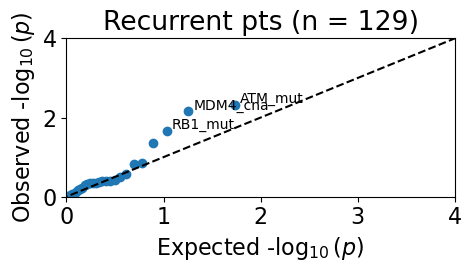

In [42]:
# P-value QQ Plot
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (5,3)

srt_idx = np.argsort(stat_results_df["p"]) + 0.5
stat_results_df["quantile"] = srt_idx/(stat_results_df.shape[0] - 0.0)
plt.scatter(-np.log10(stat_results_df["quantile"]), -np.log10(stat_results_df["p"]))
plt.plot([-1,4],[-1,4], linestyle="--", color="k")

for i, si in enumerate(srt_idx[:3]):
    plt.text(-np.log10(stat_results_df["quantile"].values[i])+0.05, -np.log10(stat_results_df["p"].values[i])+0.05,
             stat_results_df.index.values[i], size=10)

plt.xlim([-0.0,4])
plt.ylim([-0.0,4])
plt.xlabel("Expected -$\log_{10}(p)$")
plt.ylabel("Observed -$\log_{10}(p)$")
plt.title(f'Recurrent pts (n = {len(cox_r)})')
plt.tight_layout()
plt.show()

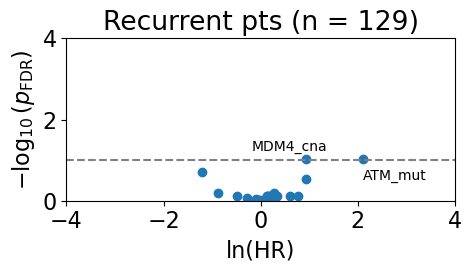

In [43]:
# Volcano plot
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = (5,3)

ax = plt.gca()
ax.scatter(np.log(stat_results_df['exp(coef)']), -np.log10(stat_results_df['p_adj']))
ax.set_xlim(-4, 4)
ax.set_ylim(0, 4)
ax.set_xlabel('ln(HR)')
ax.set_ylabel('$-\log_{10}{(p_{\mathrm{FDR}})}$')
ax.axhline(y = -np.log10(0.1), color = 'grey', linestyle = '--')

for i, row in stat_results_df[stat_results_df['p_adj'] < 0.1].iterrows():
    if i == 'MDM4_cna':
        ax.text(np.log(row['exp(coef)']-1.7), -np.log10(row['p_adj'])+0.2, i, size=10)
    elif i == 'TP53_cna':
        ax.text(np.log(row['exp(coef)']), -np.log10(row['p_adj'])+0.2, i, size=10)
    else:
        ax.text(np.log(row['exp(coef)']+0.05), -np.log10(row['p_adj'])-0.5, i, size=10)


plt.title(f'Recurrent pts (n = {len(cox_r)})')
plt.tight_layout()
plt.show()

# Save mutational information for lollipop plots

In [45]:
lollipop = muts_filt[muts_filt['Hugo_Symbol'].isin(['PDGFRA', 'ATM'])]
lollipop.to_csv('../results/PDGFRA_and_ATM_mutations.tsv', sep = '\t', index = False)

# Follow-up on some significant findings using ssGSEA measures of subtype enrichment

In [47]:
import seaborn as sns
from scipy.stats import mannwhitneyu

Inner join - look only at pts with pre-ICB DNA (OncoPanel or WES)

In [48]:
ssgsea_path = "../data/icb_ssgsea_results.tsv" #'../../../../merrell_cgaprojects-ibm-gbm/analysis/ssgsea/ssgsea_results.tsv' #  ssgsea/2024-04-16/ssgsea_results.tsv'
ssgsea = pd.read_csv(ssgsea_path, sep = '\t', index_col = 0)
ssgsea = ssgsea.loc[ssgsea.index.isin(sample_sheet.loc[sample_sheet['usable_rnaseq'], 'sample_id_legacy'])]
ssgsea = ssgsea[ssgsea['pre_post'] == 'Pre']
ssgsea = ssgsea.merge(clinical[['participant_id_legacy', 'icb_setting']], how = 'inner', left_on = 'participant_id', right_on = 'participant_id_legacy')

ssgsea['ICB setting'] = np.where(ssgsea['icb_setting'] == 1.0, 'Newly diagnosed', 'Recurrent')

ssgsea['participant_id'].nunique()

37

## Matching by patient

In [49]:
for x in ['TP53_cna', 'MDM4_cna', 'ATM_mut', 'PDGFRA_mut', 'CDKN2A_cna', 'NF1_mut', 'NF1_cna']:
    ssgsea[x] = ssgsea['participant_id'].isin(cox[cox[x] == 1]['participant_id_legacy']).astype(str)
    print(ssgsea[x].value_counts())

False    39
True      3
Name: TP53_cna, dtype: int64
False    38
True      4
Name: MDM4_cna, dtype: int64
False    42
Name: ATM_mut, dtype: int64
False    39
True      3
Name: PDGFRA_mut, dtype: int64
False    25
True     17
Name: CDKN2A_cna, dtype: int64
False    37
True      5
Name: NF1_mut, dtype: int64
False    36
True      6
Name: NF1_cna, dtype: int64


In [51]:
combinations_to_plot = [[x, y] for x in ['PDGFRA_mut', 'CDKN2A_cna', 'NF1_mut', 'NF1_cna'] for y in ['VERHAAK_GLIOBLASTOMA_PRONEURAL', 'VERHAAK_GLIOBLASTOMA_MESENCHYMAL', 'VERHAAK_GLIOBLASTOMA_CLASSICAL', 'VERHAAK_GLIOBLASTOMA_NEURAL']]
combinations_to_plot

[['PDGFRA_mut', 'VERHAAK_GLIOBLASTOMA_PRONEURAL'],
 ['PDGFRA_mut', 'VERHAAK_GLIOBLASTOMA_MESENCHYMAL'],
 ['PDGFRA_mut', 'VERHAAK_GLIOBLASTOMA_CLASSICAL'],
 ['PDGFRA_mut', 'VERHAAK_GLIOBLASTOMA_NEURAL'],
 ['CDKN2A_cna', 'VERHAAK_GLIOBLASTOMA_PRONEURAL'],
 ['CDKN2A_cna', 'VERHAAK_GLIOBLASTOMA_MESENCHYMAL'],
 ['CDKN2A_cna', 'VERHAAK_GLIOBLASTOMA_CLASSICAL'],
 ['CDKN2A_cna', 'VERHAAK_GLIOBLASTOMA_NEURAL'],
 ['NF1_mut', 'VERHAAK_GLIOBLASTOMA_PRONEURAL'],
 ['NF1_mut', 'VERHAAK_GLIOBLASTOMA_MESENCHYMAL'],
 ['NF1_mut', 'VERHAAK_GLIOBLASTOMA_CLASSICAL'],
 ['NF1_mut', 'VERHAAK_GLIOBLASTOMA_NEURAL'],
 ['NF1_cna', 'VERHAAK_GLIOBLASTOMA_PRONEURAL'],
 ['NF1_cna', 'VERHAAK_GLIOBLASTOMA_MESENCHYMAL'],
 ['NF1_cna', 'VERHAAK_GLIOBLASTOMA_CLASSICAL'],
 ['NF1_cna', 'VERHAAK_GLIOBLASTOMA_NEURAL']]

In [52]:
icb_setting_colors = palettable.colorbrewer.diverging.PRGn_3.mpl_colors
icb_setting_mapping = {'Newly diagnosed': icb_setting_colors[0], 'Recurrent': icb_setting_colors[2]}

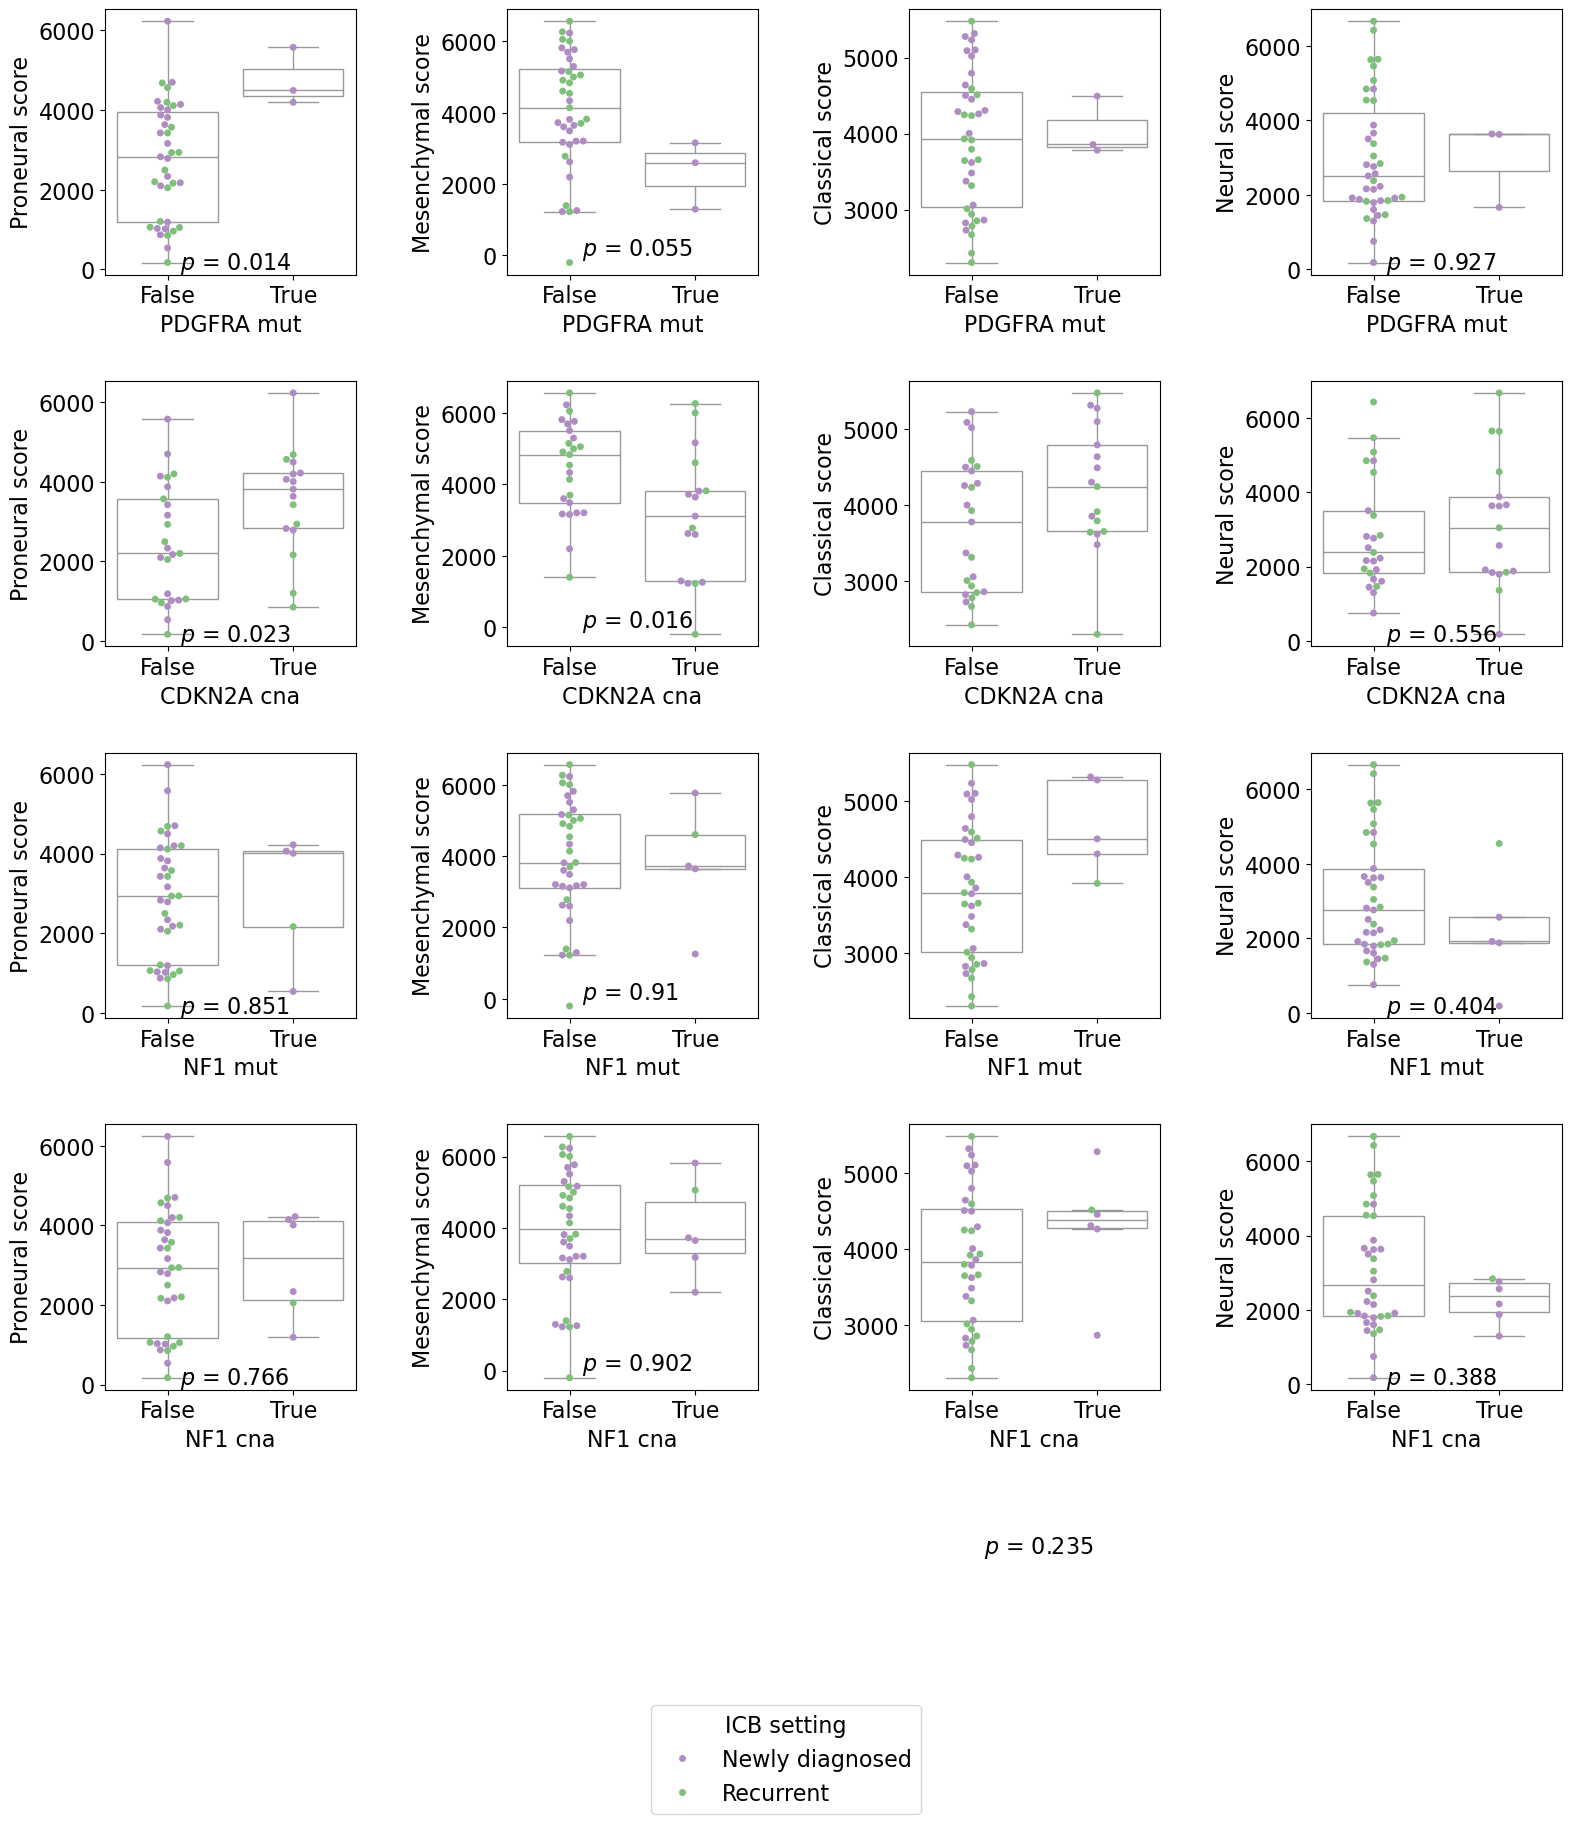

In [55]:
fig, axs_nonflat = plt.subplots(4, 4, figsize = (16,16))
axs = axs_nonflat.flat

for i, (x, y) in enumerate(combinations_to_plot):
    
    result = mannwhitneyu(x = ssgsea.loc[ssgsea[x] == 'True', y],
                          y = ssgsea.loc[ssgsea[x] == 'False', y])
    
    xlab = x.replace('_', ' ')
    ylab = y.split('_')[-1].capitalize() + ' score'

    sns.boxplot(ax = axs[i], data = ssgsea, x = x, y = y, fliersize = 0, color = 'white')
    sns.swarmplot(ax = axs[i], data = ssgsea, x = x, y = y, hue = 'ICB setting', size = 5,
                      palette = icb_setting_mapping)
    axs[i].set_xlabel(xlab)
    axs[i].set_ylabel(ylab)
    
    axs[i].text(0.1, 0.025, f'$p$ = {round(result.pvalue, 3)}')
    
h, l = axs[0].get_legend_handles_labels()

fig.legend(h, l, title = 'ICB setting', loc = 'lower center', bbox_to_anchor = (0.5,-0.15))

[axs[i].get_legend().remove() for i in range(16)]

plt.tight_layout()
plt.subplots_adjust(hspace = 0.4, wspace = 0.6)
plt.show()